In [2]:
# kết nối với gg drive
import os
from google.colab import drive
drive.mount('/content/drive')

os.chdir('/content/drive/MyDrive/NLP 4+1/BTL3- BERT and GPT/dataset/')
os.getcwd()

Mounted at /content/drive


'/content/drive/.shortcut-targets-by-id/1bs2wermM-w1hKEOcHyv-UmLHY5iag5cm/NLP 4+1/BTL3- BERT and GPT/dataset'

# 1. Import các thư viện cần thiết

In [3]:
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 2. Load dữ liệu

In [7]:
#link data: https://github.com/LasseRegin/medical-question-answer-data
with open(f'./webmdQAs.json') as f:
    data = json.load(f)
len(data)

23437

In [9]:
data[0]

{'answer': "adhd and bipolar mood disorder (bmd) can coexist or be mistaken for one another. bmd usually is not diagnosed until young adulthood. however studies have shown that the earlier a person is diagnosed with bmd the more likely he is to have been diagnosed with adhd previously. in this case i would just like to reiterate that there is not enough information to discuss either possibility for your son. you mentioned that he becomes hyperactive for 3 weeks but not what his behaviors are like during those 10 days. you also do not mention irritability or mood swings just adhd symptoms. keep documenting the symptoms you are concerned about including what goes on in the home and at school when you see changes in behavior (do you work those weeks does he visit a relative or have a different aide in the classroom). you also mentioned that this began 7 months ago. i would also urge you to think about what also might have changed in your son's life about that time. consulting your pediatr

In [14]:
#function to extract question,answer and tags from the json objects
def extract_answer_question_tags(json_data):
    questions=[]
    answers=[]
    for i in json_data:
        questions.append(i['question'])
        answers.append(i['answer'])
    return questions,answers

questions,answers = extract_answer_question_tags(data)

In [15]:
df = pd.DataFrame({'questions':questions,'answers':answers})
df

,questions,answers
0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...
1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...
2,my son is 13 and is depressed. he has been tak...,while any of the stimulant medications can inc...
3,my 17-year-old has stopped taking concerta aft...,seventy percent of teens diagnosed when they a...
4,i've been taking respa-ar for allergies. i can...,try claritin-d which is located behind the pha...
...,...,...
23432,how can accidental of acetaminophen overdose b...,to avoid unintentional overdoses among adults ...
23433,what should i do if i take an overdose of maxalt?,if you take more medication than you have been...
23434,what do i do in case of an overdose of relpax?,call your doctor or poison control center or g...
23435,is overdose with acetaminophen usually acciden...,in the u. s. suicide attempts account for over...


In [16]:
df.isna().sum()

questions    0
answers      0
dtype: int64

In [17]:
df.duplicated().sum()

0

# 3. Tiền xử lý dữ liệu

In [18]:
import re
def decontractions(phrase):
    """decontracted takes text and convert contractions into natural form.
     ref: https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490"""
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)

    return phrase


def preprocess(text):
    # convert all the text into lower letters
    # remove the words betweent brakets ()
    # remove these characters: {'$', ')', '?', '"', '’', '.',  '°', '!', ';', '/', "'", '€', '%', ':', ',', '('}
    # replace these spl characters with space: '\u200b', '\xa0', '-', '/'
    
    text = text.lower()
    text = decontractions(text)
    text = re.sub(r'[!“”"’#$%&\()*+,./:;<=>?@[\]^_`{|}~]', "", text)
    text = re.sub('\u200b', ' ', text)
    text = re.sub('\xa0', ' ', text)
    text = re.sub('-', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [19]:
df['question_preprocess'] = df['questions'].apply(preprocess)
df['answer_preprocess'] = df['answers'].apply(preprocess)
df.head(2)

,questions,answers,question_preprocess,answer_preprocess
0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...,my 5 12 year old son displays adhd symptoms fo...,adhd and bipolar mood disorder bmd can coexist...
1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...,my son has add and mild autism he has been suc...,stimulants in general tend to decrease appetit...


In [20]:
#finding the lens of preprocessed questions and answers
df['question_len'] = df['question_preprocess'].apply(lambda x: len(x.split()))
df['answer_len'] = df['answer_preprocess'].apply(lambda x: len(x.split()))
df.head(2)

,questions,answers,question_preprocess,answer_preprocess,question_len,answer_len
0,my 5 1/2-year-old son displays adhd symptoms f...,adhd and bipolar mood disorder (bmd) can coexi...,my 5 12 year old son displays adhd symptoms fo...,adhd and bipolar mood disorder bmd can coexist...,25,191
1,my son has add and mild autism. he has been su...,stimulants in general tend to decrease appetit...,my son has add and mild autism he has been suc...,stimulants in general tend to decrease appetit...,23,225


# 4. Phân tích

Text(0.5, 1.0, 'answer_len counts')

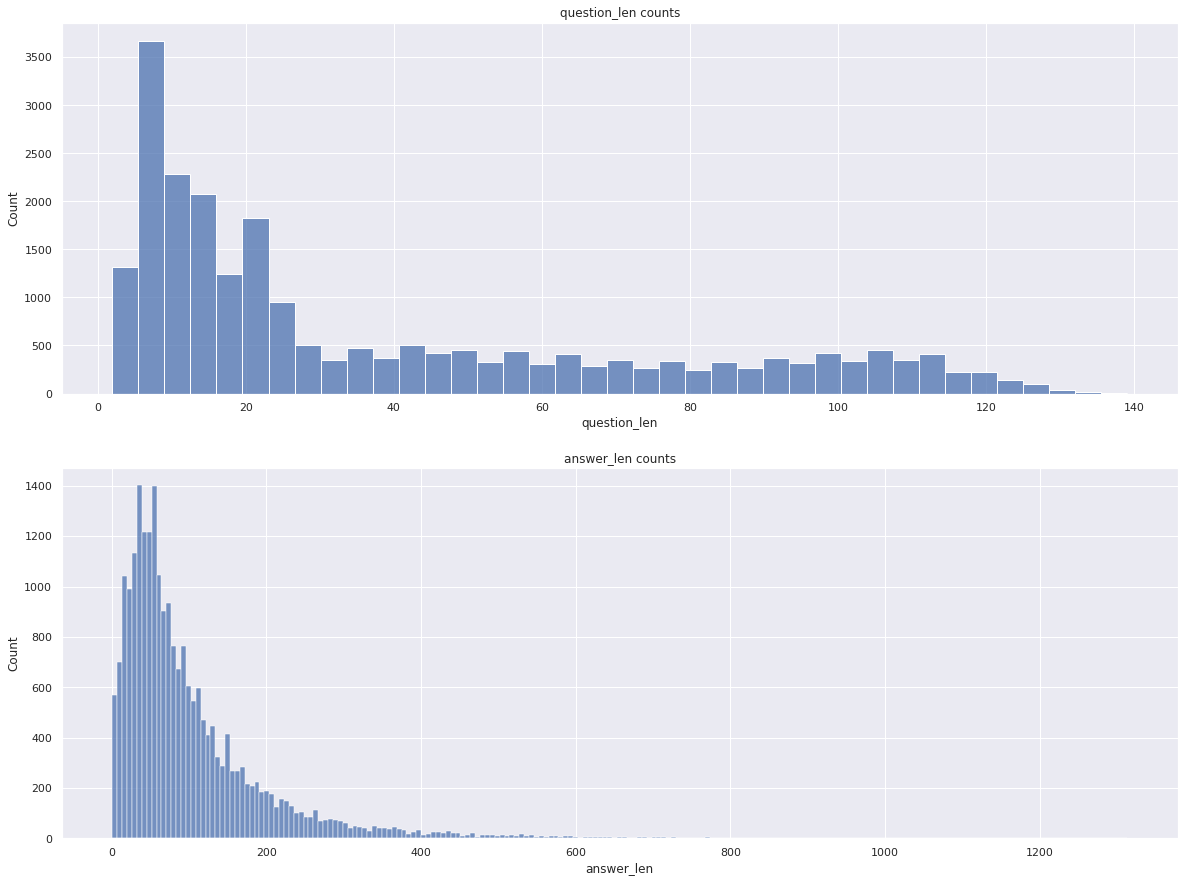

In [31]:
import seaborn as sns

sns.set(rc={'figure.figsize':(20,15)})
fig, (ax1, ax2) = plt.subplots(2,1)

sns.histplot(df['question_len'], ax = ax1)
ax1.set_title("question_len counts")

sns.histplot(df['answer_len'], ax= ax2)
ax2.set_title("answer_len counts")

## 4.1 Question

<Axes: >

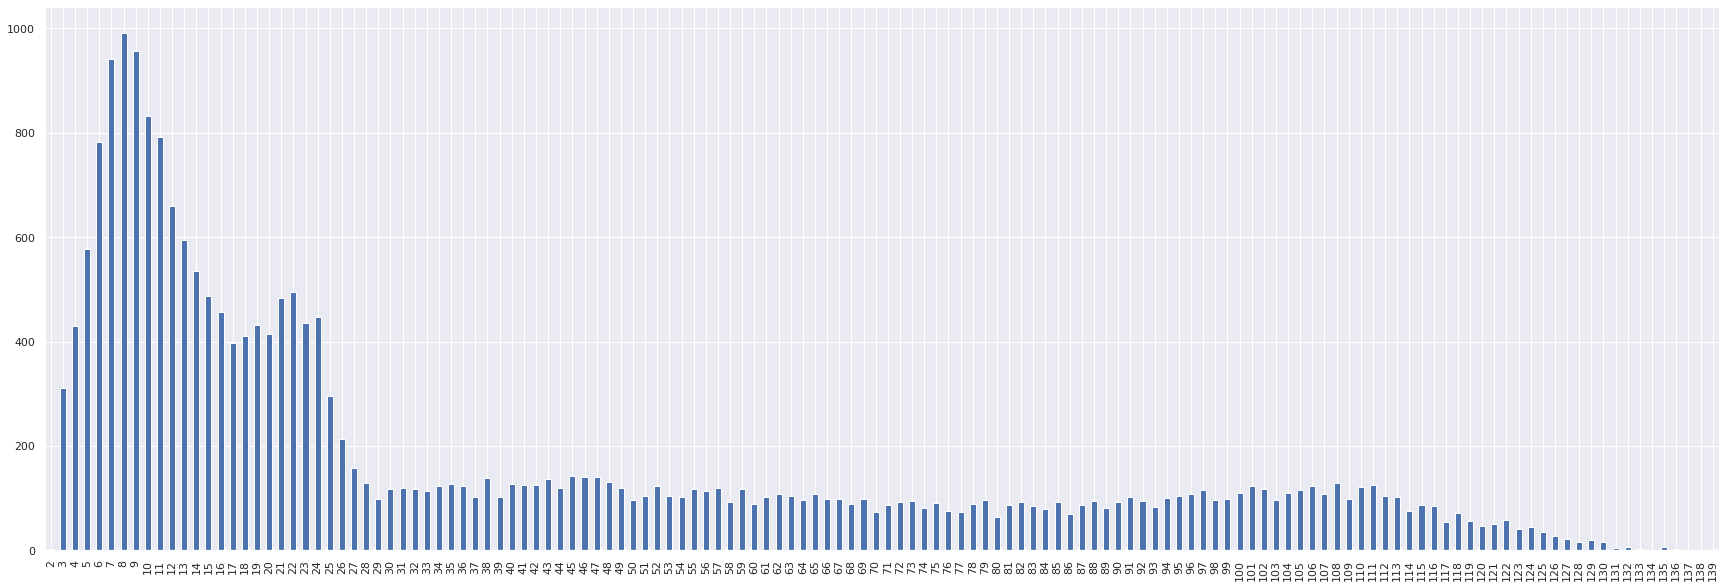

In [32]:
g_ques = df['question_len'].value_counts().sort_index()
g_ques.plot(kind='bar', figsize=(30,10))

In [34]:
df['question_len'].describe()

count    23437.000000
mean        38.586295
std         35.389133
min          2.000000
25%         11.000000
50%         22.000000
75%         62.000000
max        139.000000
Name: question_len, dtype: float64

## 4.2 Answer

<Axes: >

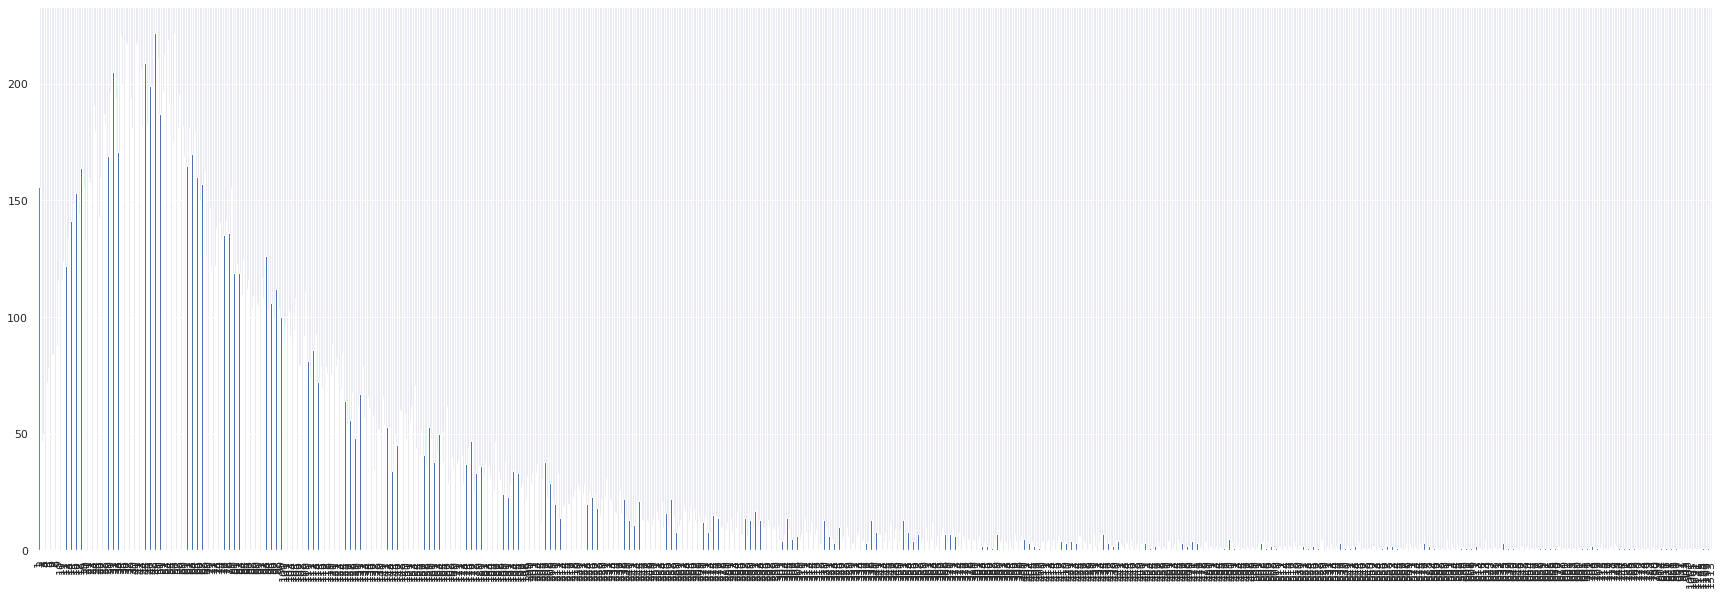

In [35]:
g_ans = df['answer_len'].value_counts().sort_index()
g_ans.plot(kind='bar', figsize=(30,10))

<Axes: >

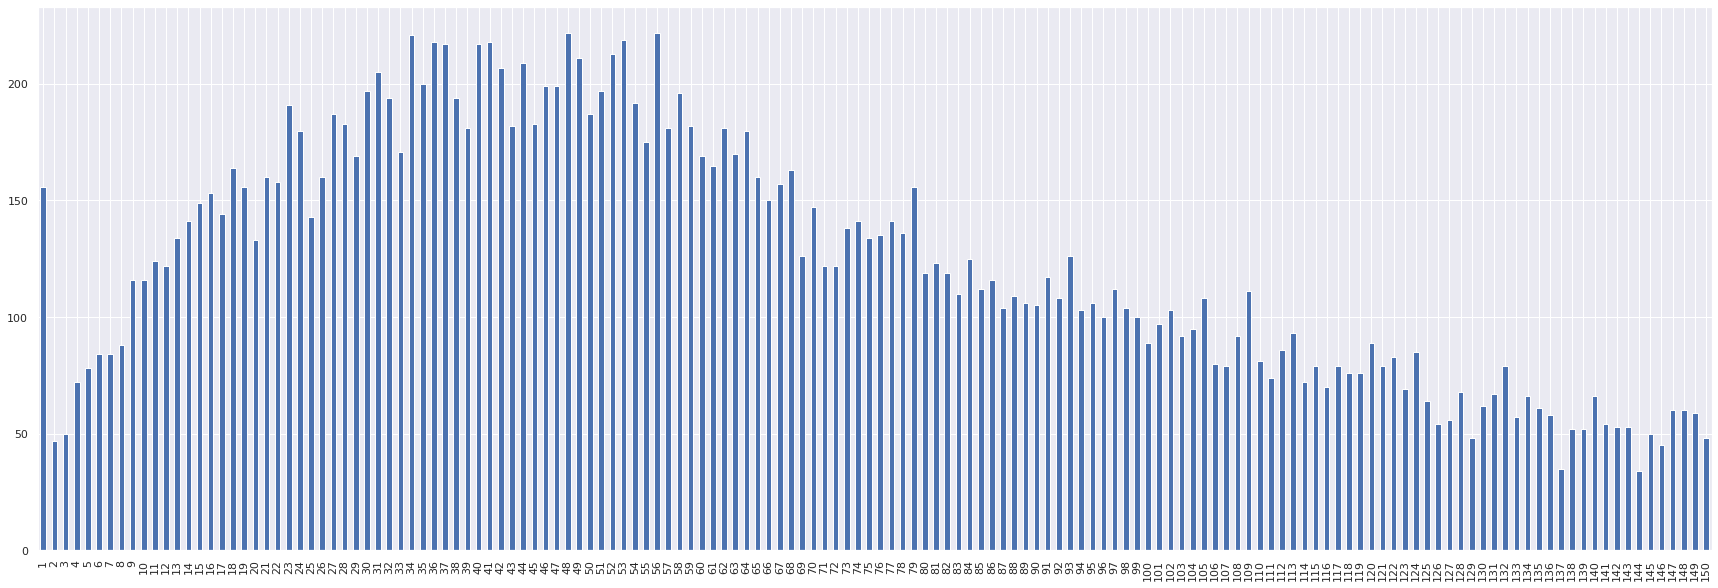

In [36]:
g_ans[:150].plot(kind='bar', figsize=(30,10))

<Axes: >

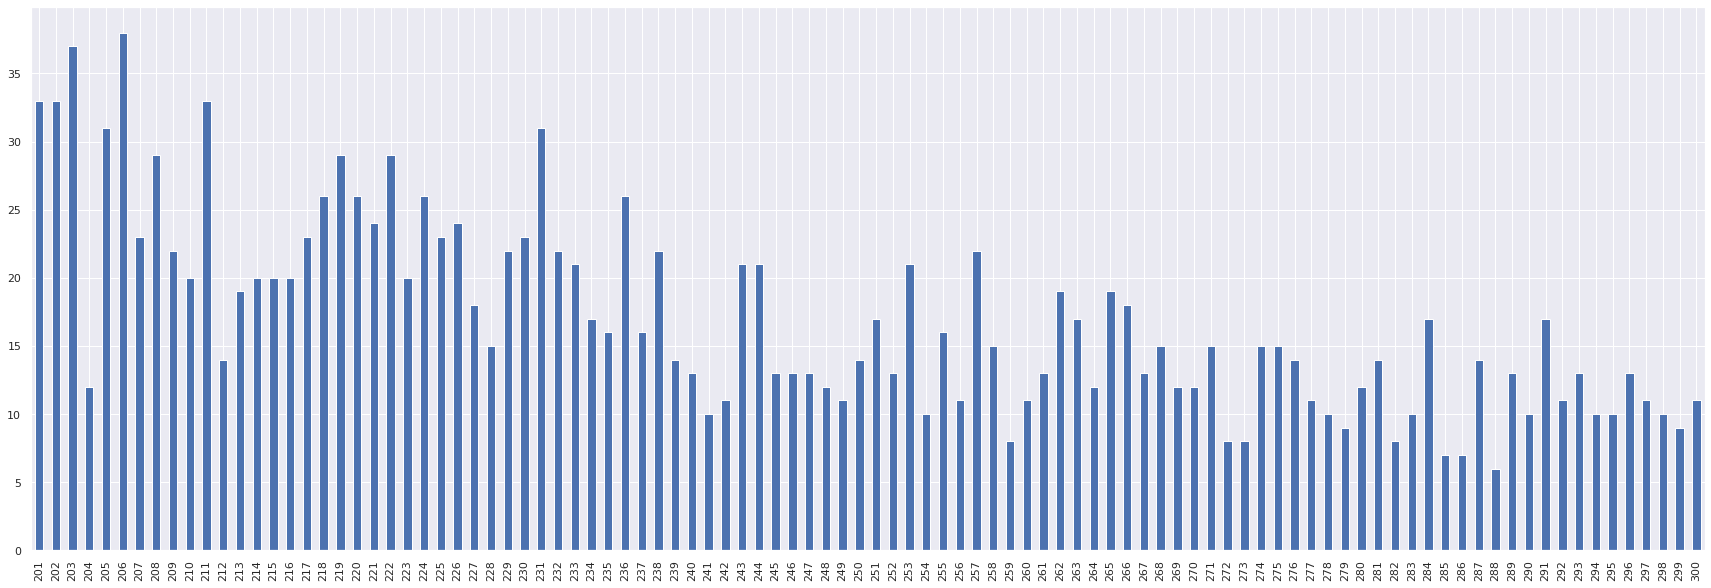

In [37]:
g_ans[200:300].plot(kind='bar', figsize=(30,10))

<Axes: >

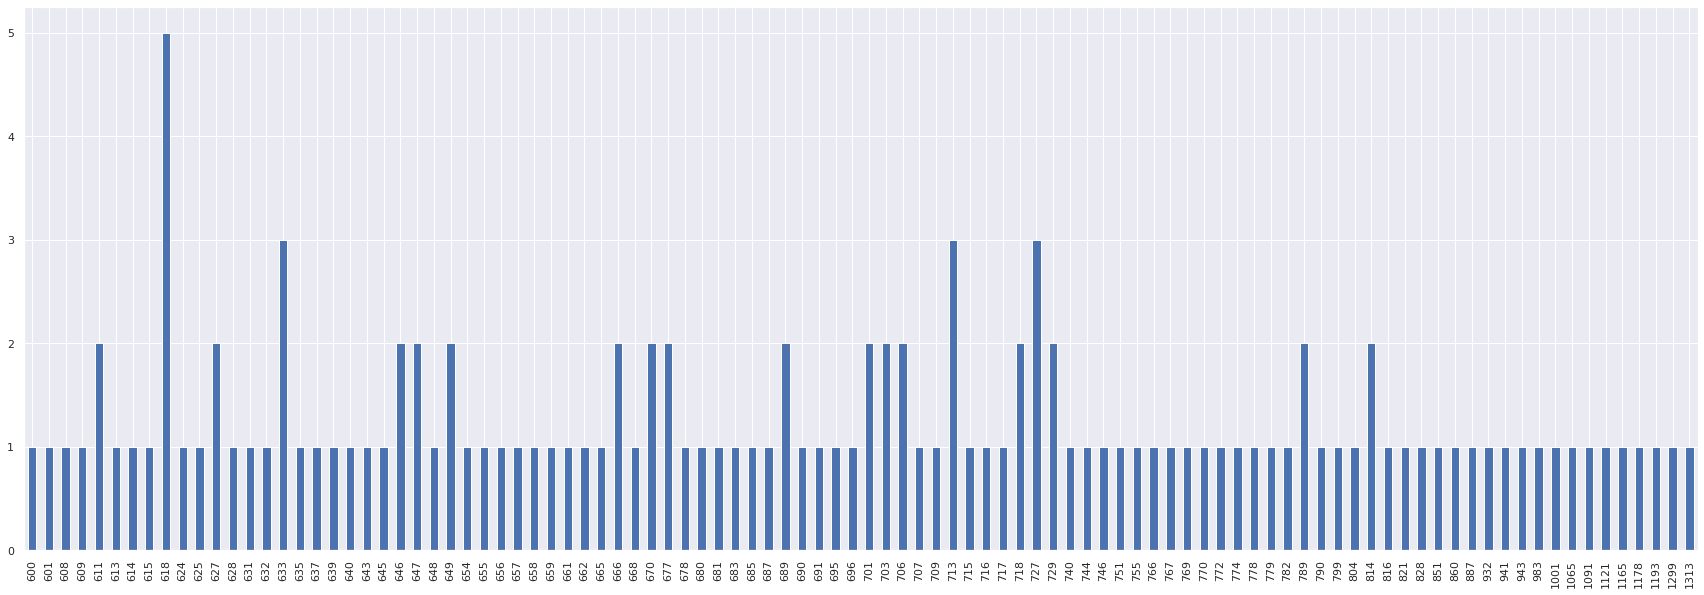

In [38]:
g_ans[-100:].plot(kind='bar', figsize=(30,10))

In [39]:
df['answer_len'].describe()

count    23437.000000
mean       103.363272
std        103.343598
min          1.000000
25%         40.000000
50%         71.000000
75%        131.000000
max       1313.000000
Name: answer_len, dtype: float64

## 4.3 Question & Answer

In [40]:
#printing different percentiles of question and answer lengths
import numpy as np
print('%\t ques\t ans')
for i in range(0,90,10):
    print(i,'\t',int(np.percentile(df['question_len'],i)), '\t', int(np.percentile(df['answer_len'],i)))
for i in range(90,101,1):
    print(i,'\t',int(np.percentile(df['question_len'],i)), '\t', int(np.percentile(df['answer_len'],i)))

%	 ques	 ans
0 	 2 	 1
10 	 7 	 21
20 	 9 	 34
30 	 12 	 45
40 	 17 	 57
50 	 22 	 71
60 	 32 	 90
70 	 51 	 114
80 	 74 	 152
90 	 100 	 220
91 	 102 	 231
92 	 104 	 244
93 	 106 	 260
94 	 108 	 277
95 	 110 	 298
96 	 113 	 331
97 	 115 	 368
98 	 118 	 426
99 	 123 	 525
100 	 139 	 1313


In [41]:
df[df['question_len'] == 2]

,questions,answers,question_preprocess,answer_preprocess,question_len,answer_len
2601,clearify plz,"webmd answer posting do not appear as a ""strin...",clearify plz,webmd answer posting do not appear as a string...,2,52
2615,whatdoesitmeantohaveaperiodthatlookslikedriedb...,please re-post your question in the space prov...,whatdoesitmeantohaveaperiodthatlookslikedriedb...,please re post your question in the space prov...,2,24


In [42]:
df[df['answer_len'] == 1]

,questions,answers,question_preprocess,answer_preprocess,question_len,answer_len
1983,will alpralozam show up in your urine 30 min a...,probably.,will alpralozam show up in your urine 30 min a...,probably,14,1
2261,severe poison ivy. starting prednisone tomorro...,yes.,severe poison ivy starting prednisone tomorrow...,yes,31,1
2269,can you take benadryl if you are taking methyl...,yes.,can you take benadryl if you are taking methyl...,yes,9,1
2441,should a 10 month old baby get the antitoxin t...,no.,should a 10 month old baby get the antitoxin t...,no,14,1
2766,colonoscopy tomorrow but started my menstrual ...,yes.,colonoscopy tomorrow but started my menstrual ...,yes,13,1
...,...,...,...,...,...,...
22483,what is anemia related to cancer?,yes,what is anemia related to cancer,yes,6,1
23113,can an individual have more than one type of a...,absolutely.,can an individual have more than one type of a...,absolutely,13,1
23114,can an individual have more than one type of a...,yes.,can an individual have more than one type of a...,yes,13,1
23129,what is the best pain and other management for...,advil,what is the best pain and other management for...,advil,123,1


# 5. Tách dữ liệu với Question(maxlen = 32) & Answer(maxlen = 64)

In [43]:
df_new = df[(df['question_len'] > 2) & (df['question_len'] <= 32) & (df['answer_len'] <= 64)].reset_index(drop=True)
df_new

,questions,answers,question_preprocess,answer_preprocess,question_len,answer_len
0,i've been taking respa-ar for allergies. i can...,try claritin-d which is located behind the pha...,i have been taking respa ar for allergies i ca...,try claritin d which is located behind the pha...,24,25
1,i have trouble swallowing pills. can my prescr...,some medications are available in liquid formu...,i have trouble swallowing pills can my prescri...,some medications are available in liquid formu...,13,42
2,lactose intolerance. does lactose build up in ...,lactose does not build up in your system but t...,lactose intolerance does lactose build up in y...,lactose does not build up in your system but t...,26,47
3,do ace inhibitors cause weight gain? . long te...,weight gain is not a common side effect of ace...,do ace inhibitors cause weight gain long term ...,weight gain is not a common side effect of ace...,23,37
4,does acupuncture aid weight loss,some science reveals that certain types of acu...,does acupuncture aid weight loss,some science reveals that certain types of acu...,5,59
...,...,...,...,...,...,...
6460,what should i do if i suspect an overdose of k...,if overdose is suspected contact your local po...,what should i do if i suspect an overdose of k...,if overdose is suspected contact your local po...,14,37
6461,what should i do if i suspect an overdose of l...,if overdose is suspected contact a poison cont...,what should i do if i suspect an overdose of l...,if overdose is suspected contact a poison cont...,12,48
6462,what should i do if i suspect an overdose of o...,if overdose is suspected contact your local po...,what should i do if i suspect an overdose of o...,if overdose is suspected contact your local po...,11,45
6463,what should i do if i take an overdose of maxalt?,if you take more medication than you have been...,what should i do if i take an overdose of maxalt,if you take more medication than you have been...,11,26


In [44]:
# lọc dữ liệu có 2 < question_len <= 32 và answer_len <= 64
df_new = df[(df['question_len'] > 2) & (df['question_len'] <= 32) & (df['answer_len'] <= 64)].reset_index(drop=True)
df_new = df_new[['question_preprocess', 'answer_preprocess']]
df_new = df_new.rename(columns={'question_preprocess': 'question', 'answer_preprocess': 'answer'})

# chia dữ liệu thành train, validation, test
df_tmp, df_test = train_test_split(df_new, test_size= 100, random_state=42, shuffle=True)
df_train, df_validation = train_test_split(df_tmp, test_size= 100, random_state=42, shuffle=True)

# lưu dữ liệu
df_train.to_csv('./train.csv', index=False)
df_validation.to_csv('./validation.csv', index=False)
df_test.to_csv('./test.csv', index=False)

print(len(df_train), len(df_validation), len(df_test))
display(df_new)

6265 100 100


,question,answer
0,i have been taking respa ar for allergies i ca...,try claritin d which is located behind the pha...
1,i have trouble swallowing pills can my prescri...,some medications are available in liquid formu...
2,lactose intolerance does lactose build up in y...,lactose does not build up in your system but t...
3,do ace inhibitors cause weight gain long term ...,weight gain is not a common side effect of ace...
4,does acupuncture aid weight loss,some science reveals that certain types of acu...
...,...,...
6460,what should i do if i suspect an overdose of k...,if overdose is suspected contact your local po...
6461,what should i do if i suspect an overdose of l...,if overdose is suspected contact a poison cont...
6462,what should i do if i suspect an overdose of o...,if overdose is suspected contact your local po...
6463,what should i do if i take an overdose of maxalt,if you take more medication than you have been...
